##Steps:
1.Add Gaussian noise to the image.

2.It’s required to apply two filters to the
image:


*   average filter  
*   morphological filter


3.Discuss the output images obtained after
applying each filter.

In [1]:
#1. Setup: Downloading the Grayscale Test Images
import numpy as np
import cv2  # OpenCV for image processing
import requests
from io import BytesIO
from PIL import Image

# URLs for the public domain test images (grayscale .pgm format)
url_cameraman = "https://web.eecs.utk.edu/~hqi/ece472-572/testimage/cameraman.pgm"
url_einstein  = "https://web.eecs.utk.edu/~hqi/ece472-572/testimage/einstein.pgm"

def download_image(url):
    """Download an image from a URL and return it as a grayscale NumPy array."""
    response = requests.get(url)
    response.raise_for_status()  # ensure the request was successful
    # Open the image with PIL directly from the response bytes
    image = Image.open(BytesIO(response.content))
    image = image.convert('L')   # convert to grayscale mode 'L' if not already
    return np.array(image)

# Download the images
cameraman = download_image(url_cameraman)
einstein  = download_image(url_einstein)

# Check shapes to ensure images loaded correctly (should print (height, width) for each)
print("Cameraman image shape:", cameraman.shape)
print("Einstein image shape:", einstein.shape)


Cameraman image shape: (256, 256)
Einstein image shape: (256, 256)


In [2]:
#2. Adding Gaussian Noise to the Images
def add_gaussian_noise(image, sigma):
    """Add Gaussian noise with standard deviation sigma to a grayscale image."""
    # Generate Gaussian noise array with the same shape as the image
    noise = np.random.normal(loc=0, scale=sigma, size=image.shape)
    # Add noise to image (convert to float to avoid overflow, then back to uint8)
    noisy_image = image.astype(np.float32) + noise
    # Clip values to valid range [0, 255] and convert back to unsigned 8-bit
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Set noise standard deviation (feel free to adjust sigma for experimentation)
sigma = 20  # e.g., 20 intensity levels standard deviation

# Create noisy versions of the images
noisy_cameraman = add_gaussian_noise(cameraman, sigma)
noisy_einstein  = add_gaussian_noise(einstein, sigma)


In [3]:
#3. Denoising with an Average Filter (Mean Filter)
def apply_mean_filter(image, kernel_size=3):
    """Apply an averaging filter of given kernel size (kernel_size x kernel_size) to the image."""
    # Use OpenCV's blur (box filter) function for averaging
    return cv2.blur(image, (kernel_size, kernel_size))

# Apply a mean filter to the noisy images (using a 5x5 kernel in this example)
mean_kernel_size = 5
denoised_mean_cameraman = apply_mean_filter(noisy_cameraman, kernel_size=mean_kernel_size)
denoised_mean_einstein  = apply_mean_filter(noisy_einstein,  kernel_size=mean_kernel_size)


In [4]:
#4. Denoising with a Morphological Filter (Opening)
def apply_morphological_open(image, kernel_size=3):
    """Apply a morphological opening (erosion followed by dilation) with a given kernel size."""
    # Create a square structuring element of the specified size
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    # Apply morphological opening
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opened_image

# Apply a morphological opening filter to the noisy images (using a 3x3 structuring element)
morph_kernel_size = 3
denoised_morph_cameraman = apply_morphological_open(noisy_cameraman, kernel_size=morph_kernel_size)
denoised_morph_einstein  = apply_morphological_open(noisy_einstein,  kernel_size=morph_kernel_size)


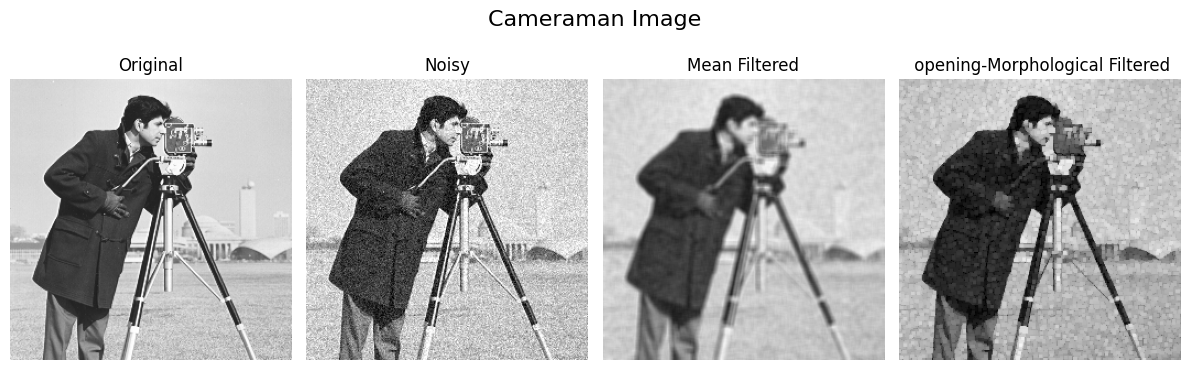

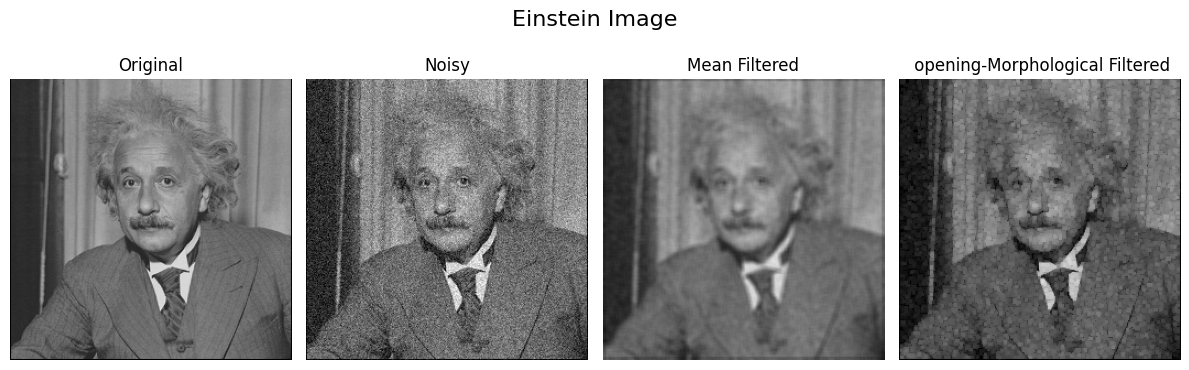

In [11]:
#5. Displaying the Original, Noisy, and Filtered Images
import matplotlib.pyplot as plt

# Utility to display results side by side for a given image
def show_comparison(original, noisy, mean_filtered, morph_filtered, title):
    plt.figure(figsize=(12,4))
    images = [original, noisy, mean_filtered, morph_filtered]
    labels = ["Original", "Noisy", "Mean Filtered", " opening-Morphological Filtered"]
    for i, (img, lbl) in enumerate(zip(images, labels)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.title(lbl)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show side-by-side comparisons for both images
show_comparison(cameraman, noisy_cameraman, denoised_mean_cameraman, denoised_morph_cameraman, title="Cameraman Image")
show_comparison(einstein,  noisy_einstein,  denoised_mean_einstein,  denoised_morph_einstein,  title="Einstein Image")


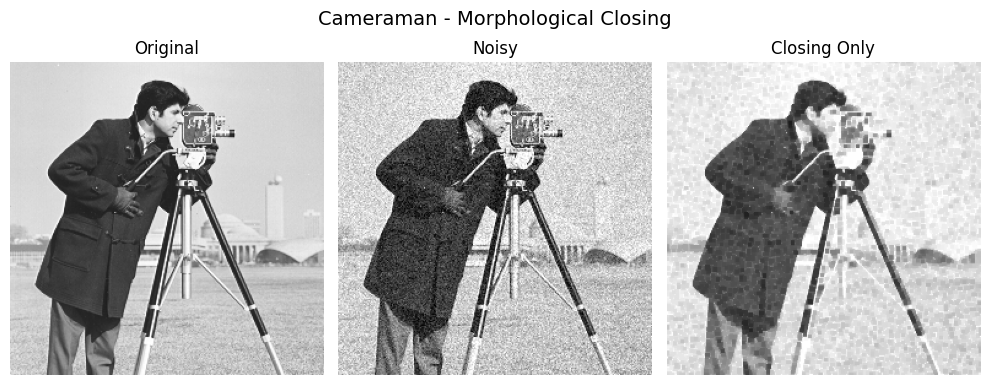

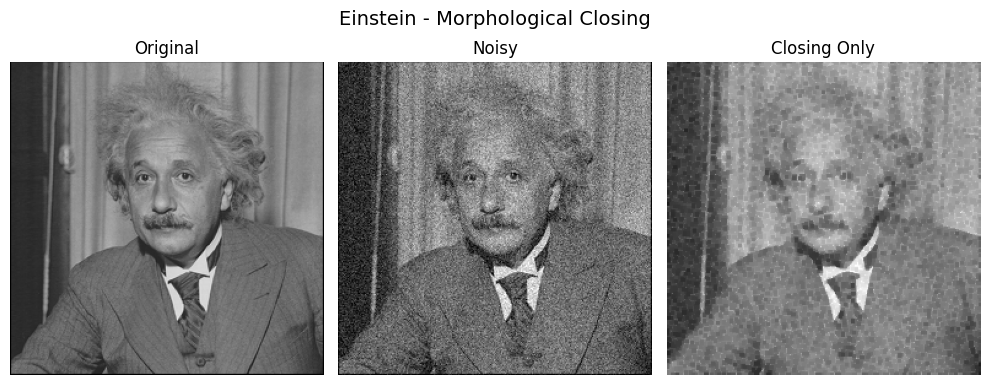

In [10]:
import matplotlib.pyplot as plt

# Apply closing to both noisy images
closed_cameraman = apply_morphological_closing(noisy_cameraman, kernel_size=3)
closed_einstein  = apply_morphological_closing(noisy_einstein,  kernel_size=3)

# Function to show original, noisy, and closed images
def show_closing_results(original, noisy, closed, title):
    plt.figure(figsize=(10,4))
    titles = ["Original", "Noisy", "Closing Only"]
    images = [original, noisy, closed]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.title(titles[i])
        plt.axis('off')
    plt.suptitle(title + " - Morphological Closing", fontsize=14)
    plt.tight_layout()
    plt.show()

# Show results for both images
show_closing_results(cameraman, noisy_cameraman, closed_cameraman, "Cameraman")
show_closing_results(einstein,  noisy_einstein,  closed_einstein,  "Einstein")



In [6]:
#Opening then Closing: Removes small white noise (bright specks), then fills small black gaps (dark specks).

#Closing then Opening: Fills small black holes first, then removes small white noise.


def apply_open_then_close(image, kernel_size=3):
    """Apply morphological Opening followed by Closing."""
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return closed

def apply_close_then_open(image, kernel_size=3):
    """Apply morphological Closing followed by Opening."""
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    return opened

# Apply to both images
morph_open_close_cameraman = apply_open_then_close(noisy_cameraman, kernel_size=morph_kernel_size)
morph_close_open_cameraman = apply_close_then_open(noisy_cameraman, kernel_size=morph_kernel_size)

morph_open_close_einstein = apply_open_then_close(noisy_einstein, kernel_size=morph_kernel_size)
morph_close_open_einstein = apply_close_then_open(noisy_einstein, kernel_size=morph_kernel_size)


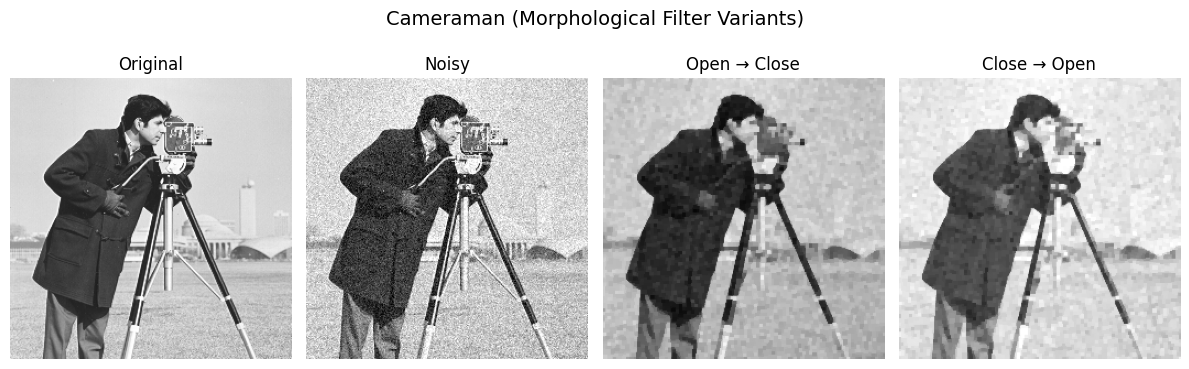

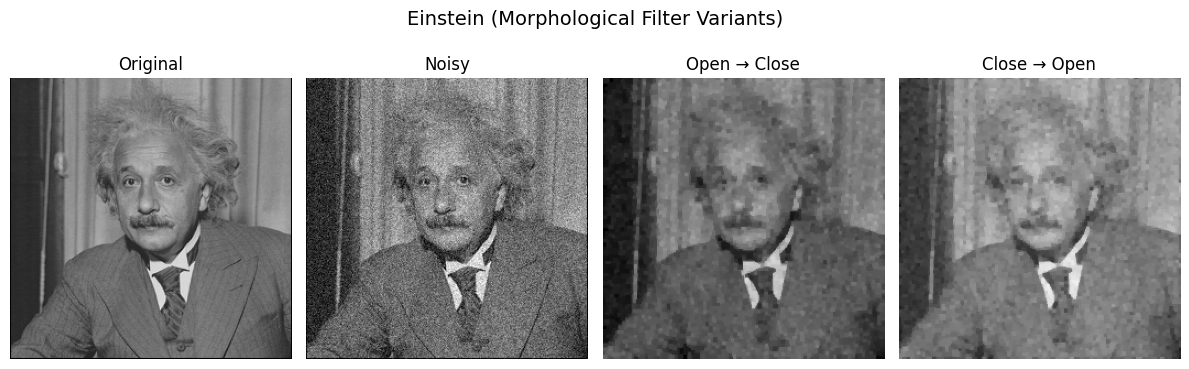

In [7]:
# Utility to show all variants of morphological filtering
def show_morph_variants(original, noisy, open_close, close_open, title):
    plt.figure(figsize=(12,4))
    images = [original, noisy, open_close, close_open]
    labels = ["Original", "Noisy", "Open → Close", "Close → Open"]
    for i, (img, lbl) in enumerate(zip(images, labels)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.title(lbl)
        plt.axis('off')
    plt.suptitle(title + " (Morphological Filter Variants)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Show morphological filtering variants
show_morph_variants(cameraman, noisy_cameraman, morph_open_close_cameraman, morph_close_open_cameraman, "Cameraman")
show_morph_variants(einstein, noisy_einstein, morph_open_close_einstein, morph_close_open_einstein, "Einstein")


##conclusion:
In this assignment, i investigated the effect of Gaussian noise on grayscale images and evaluated multiple filtering techniques for noise removal. The methods applied included an average (mean) filter, a basic morphological opening filter, and two composite morphological operations: opening followed by closing, and closing followed by opening.

After adding Gaussian noise (σ = 20) to the Cameraman and Einstein images, i observed that the average filter was the most effective in reducing noise uniformly. It produced the smoothest results and successfully eliminated most of the grain introduced by the noise. However, this came at the cost of noticeable blurring, especially around fine details and edges.

On the other hand, morphological filters, which are more commonly used for removing salt-and-pepper noise, were less effective against Gaussian noise. A single morphological opening removed small bright specks but failed to reduce darker noise pixels. When i applied combined morphological operations—opening followed by closing and closing followed by opening—the results improved slightly. These combinations managed to reduce both bright and dark noise points while preserving some structural details better than the average filter. However, residual noise remained visible, and the output was still not as clean as with the averaging method.

In conclusion, while morphological filters can be helpful in handling certain types of impulse noise, the average filter remains the most reliable technique for Gaussian noise removal in grayscale images. For applications where edge preservation is more critical, using morphological combinations can be a suitable alternative, but they are not sufficient alone for complete Gaussian denoising. Future work could explore more advanced methods such as Gaussian blur, bilateral filtering, or machine learning-based denoising techniques for better performance.

##Final Takeaway
After applying and comparing various filtering techniques on the two test images, we observed different outcomes based on the structure and content of each image:

In the Cameraman image:
The morphological opening filter performed better than both the average filter and other morphological combinations. It effectively removed much of the Gaussian noise while preserving important structural details without introducing significant blurring. The average filter, although strong in noise suppression, noticeably blurred the image, reducing fine texture and edge clarity.

In the Einstein image:
Both morphological opening and the opening followed by closing combination yielded the best results. They reduced the noise while maintaining more detail than the average filter. The combination approach was particularly useful in addressing both bright and dark noise specks, leading to a more balanced visual output.

Overall, the performance of filtering methods varies depending on image characteristics. Morphological filters, especially opening (alone or in combination), can provide a good compromise between denoising and detail preservation in some scenarios. However, for uniform Gaussian noise, averaging remains the most consistent in noise reduction, albeit with a trade-off in sharpness.